In [9]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt

from utilities import reduced_parameter as red
from field.utils import profiling_rad

import utilities.reduced_parameter as red

from utilities.etc import categorizing_result
from analyze_tools import plot_tools as pt
import analyze_tools.monte_carlo as at

def assert_path(path):
    try: 
        assert os.path.isdir(path)
    except AssertionError:
        raise Exception("Path {} is not exist".format(path))

linestyle_list = ["solid", "dashed", "dotted","dashdot"]
scatter_list = ["o", "^","v"]

In [2]:
pt = importlib.reload(pt)
red = importlib.reload(red)

In [4]:
ROOT2 = "pickle_jar/"
#ROOT = "/Users/macbook/OneDrive - Emory/Research data/mm_polariton/pickle_jar/"

temperature_list = []

temperature = 150 ; seed = 293 ; N_atoms = 1024
temperature_list.append(temperature)

free150 = ROOT2 + "probe-{}_{}_{}".format(temperature, N_atoms, seed)
cav_result_folders_list150 = [
    ROOT2 + "probe-{}_{}_{}_cavity_21_43".format(temperature, N_atoms, seed),
    ROOT2 + "probe-{}_{}_{}_cavity_43_75".format(temperature, N_atoms, seed),
    #"{}_{}_60_80_{}".format(temperature, N_atoms, seed),
]

assert_path(free150)
for path in cav_result_folders_list150:
    assert_path(path)

temperature = 292 ; seed = 731 ; 
N_atoms = 1024
temperature_list.append(temperature)

free292 = ROOT2 + "probe-{}_{}_{}".format(temperature, N_atoms, seed)
cav_result_folders_list292 = [
    ROOT2 + "probe-{}_{}_{}_cavity_26_51".format(temperature, N_atoms, seed),
    #ROOT2 + "probe-{}_{}_{}_cavity_51_85".format(temperature, N_atoms, seed),
    #"{}_{}_60_80_{}".format(temperature, N_atoms, seed),
]

assert_path(free292)
for path in cav_result_folders_list292:
    assert_path(path)

fig_root = "figure/Final_150_1024_293"
if not os.path.isdir(fig_root):
    os.mkdir(fig_root)

In [5]:
free_result_dict = categorizing_result(free292)

cave_result_dict_list = []
for path in cav_result_folders_list292:
    cave_result_dict_list.append(categorizing_result(path))

In [ ]:
dipole_plot = pt.Plot(n_dipole_plots = 3)

for i, result in free_result_dict.items():
    atoms = result['atoms']
    dipole_plot.add_dipole_plot(
        0, 
        red.convert_time(atoms.observable["t"]), 
        red.convert_dipole(atoms.observable["total_dipole"]),
        index = i
    )

for j, result_dict in enumerate(cave_result_dict_list):
    for i, result in result_dict.items():
        atoms = result['atoms']
        dipole_plot.add_dipole_plot(
            j + 1,
            red.convert_time(atoms.observable["t"]), 
            red.convert_dipole(atoms.observable["total_dipole"]),
            index = i
        )

dipole_plot.add_label(0, dip_label = ("","Total dipole (Debye)"))
dipole_plot.add_label(1, dip_label = ("","Total dipole (Debye)"))
dipole_plot.add_label(2, dip_label = ("Time (ps)","Total dipole (Debye)"))

dipole_plot.annotate(dipole_plots = True, spec_plots = False)

dipole_plot.savefig(fig_root + "/")

In [ ]:
at = importlib.reload(at)

fig,ax = plt.subplots(2)

colliding_time0 = []
for i, result in free_result_dict.items():
    atoms = result['atoms']
    time = at.get_colliding_time(atoms,red.mu0, 0)
    colliding_time0 += time

colliding_time0 = np.array(colliding_time0)

#"""
for j, result_dict in enumerate(cave_result_dict_list):
    colliding_time = []
    
    for i, result in result_dict.items():
        atoms = result['atoms']
        time = at.get_colliding_time(atoms,red.mu0, 0)
        colliding_time += time
        
    time_diff = np.array(colliding_time - colliding_time0)
    time_diff = time_diff[np.abs(time_diff) > 0.1]
    ax[j].hist(time_diff,bins = np.arange(-2,20,0.1))

#ax[0].set_xlabel("collision time (ps)")
ax[0].set_ylabel("Number of Ar-Xe pairs")

ax[1].set_xlabel("collision time difference (ps)")
ax[1].set_ylabel("Number of Ar-Xe pairs")
#"""
#fig.savefig(fig_root + '/' + 'histogram.jpeg')

In [ ]:
len(time_diff)

In [ ]:
len(colliding_time0[colliding_time0 > 0]) / len(colliding_time0)

In [ ]:
np.arcsin(1/5) / np.pi

In [ ]:
dipole_func = lambda d: red.mu0 * np.exp(-red.a * (d - red.d0)) - red.d7/d**7

for d in np.arange(0.2,5,0.1):
    print("{:.2f}\t {:.7f}".format(d, dipole_func(d)))

In [ ]:
spectrum = pt.Plot(n_spec_plots = 3)

for i in range(4,1,-1):
    em = free_result_dict[i]['probe_field']
    wavenumber = red.convert_wavenumber(em.k_val)
    final_rad_energy = red.convert_energy(em.history['energy'][-1], 'cm-1') * 1e8
    wn, erad = profiling_rad(wavenumber, final_rad_energy)

    if i == 4: wn0 = wn; erad0 = erad
    
    spectrum.add_spec_plot(
        0, wn, erad, scatter = True if i == 4 else False, 
        line_label = "after {} cycles".format(i))

spectrum.add_label(0, spec_label = ("Wavenumber (1/cm)",r'Energy ($10^{-8} cm^{-1}$)'))

#"""
for j, result_dict in enumerate(cave_result_dict_list):
    for i in range(4,1,-1):
        em = result_dict[i]['probe_field']
        wavenumber = red.convert_wavenumber(em.k_val)
        final_rad_energy = red.convert_energy(em.history['energy'][-1], 'cm-1') * 1e5
        wn, erad = profiling_rad(wavenumber, final_rad_energy)
    
        spectrum.add_spec_plot(
            j + 1, wn, erad, scatter = True if i == 4 else False, 
            line_label = "after {} cycles".format(i))

    spectrum.add_label(j + 1, spec_label = ("Wavenumber (1/cm)",r'Energy ($10^{-5} cm^{-1}$)'))
#"""

spectrum.add_legend(0)
spectrum.add_legend(1)
spectrum.add_legend(2)

spectrum.annotate(spec_plots = True)

spectrum.savefig(fig_root + '/general_')

In [ ]:
spectrum2 = pt.Plot(n_spec_plots = 2)

for j, result_dict in enumerate(cave_result_dict_list):
    em = result_dict[4]['probe_field']
    wavenumber = red.convert_wavenumber(em.k_val)
    final_rad_energy = red.convert_energy(em.history['energy'][-1], 'cm-1') * 1e5
    wn, erad = profiling_rad(wavenumber, final_rad_energy)

    spectrum2.add_spec_plot(
        j, wn, erad, scatter = False)

    spectrum2.add_spec_plot(
        j, wn0, np.array(erad0), scatter = False, linestyle = "--")

    spectrum2.add_label(j, spec_label = ("Wavenumber (1/cm)",r'Energy ($10^{-5} cm^{-1}$)'))

spectrum2.annotate(spec_plots = True)
spectrum2.savefig(fig_root + '/only_cavity_')

In [ ]:
free_result_folders

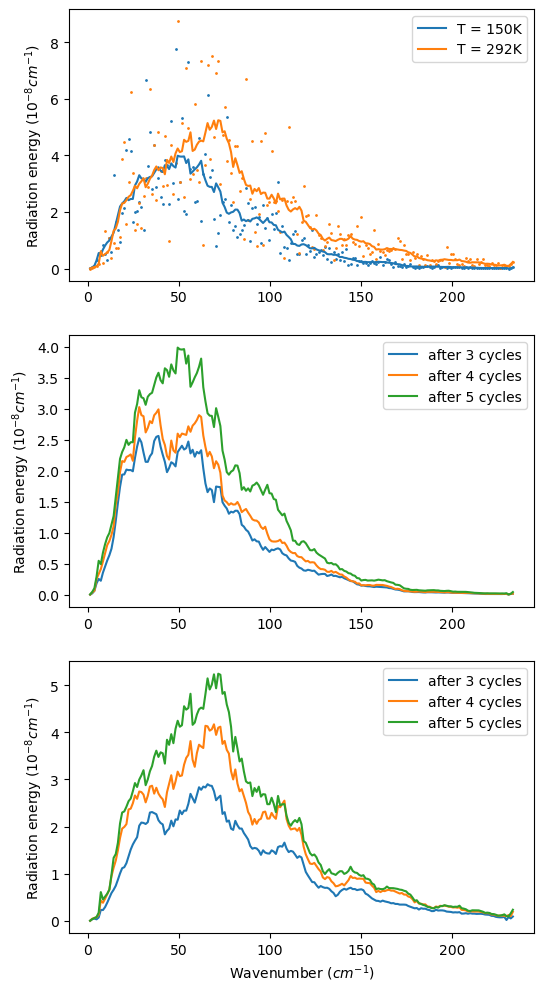

In [21]:
##############################################################
##############################################################
### PLOT SPECTRUM IN FREE SPACE FOR DIFFERENCE TEMPERATURE ###
##############################################################
##############################################################

ma_windows = 12
free_plot = pt.Plot(n_spec_plots = 3)

for i , free_result_folders in enumerate([free150, free292]):
    result_dict = categorizing_result(free_result_folders, KEYWORDS="")

    cycle = 4
    Afield = result_dict[cycle]["probe_field"]

    rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "cm-1") * 1e8
    omega = red.convert_wavenumber(Afield.k_val)
    omega_profile, final_rad_profile = profiling_rad(omega, rad_energy)

    free_plot.add_spec_plot(
        0, omega_profile, final_rad_profile, ma_w = ma_windows, 
        line_label = "T = {}K".format(temperature_list[i])
        )

    for cycle in range(2,5,1):
        Afield = result_dict[cycle]["probe_field"]

        rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "cm-1") * 1e8
        omega = red.convert_wavenumber(Afield.k_val)
        omega_profile, final_rad_profile = profiling_rad(omega, rad_energy)

        free_plot.add_spec_plot(
            i + 1, omega_profile, final_rad_profile, ma_w = ma_windows, scatter = False,
            line_label = "after {} cycles".format(cycle + 1))

free_plot.add_label(0, (None, "Radiation energy ($10^{-8} cm^{-1}$)"))
free_plot.add_legend(0)
free_plot.add_label(1, (None, "Radiation energy ($10^{-8} cm^{-1}$)"))
free_plot.add_legend(1)
free_plot.add_label(2, (r'Wavenumber $(cm^{-1})$', "Radiation energy ($10^{-8} cm^{-1}$)"))

free_plot.annotate()
free_plot.add_legend(2)

free_plot.savefig(fig_root + "/free2_field_")


In [ ]:
free_result_dict = categorizing_result(ROOT + free200, KEYWORDS="free")
nofield_result_dict = categorizing_result(ROOT2 + nofield200, KEYWORDS="nofield")

cavity_result_dict_list = []
for folder in cav_result_folders_list200:
    cavity_result_dict_list.append(
        categorizing_result(ROOT + folder, KEYWORDS = "cavity"))

In [ ]:
dipole_plot = pt.Plot(n_spec_plots = 0, n_dipole_plots = 5)
for i, result in free_result_dict.items():
    #if i >= 10 : continue
    free_obs = result["atoms"].observable
    nofield_obs = nofield_result_dict[i]["atoms"].observable
    dipole_plot.add_dipole_plot(0, nofield_obs['t'], nofield_obs['total_dipole'], index = i)
    dipole_plot.add_dipole_plot(1, free_obs['t'], free_obs['total_dipole'], index = i)

    for j, result_dict in enumerate(cavity_result_dict_list):
        cav_obs = result_dict[i]["atoms"].observable
        dipole_plot.add_dipole_plot(2 + j, cav_obs['t'], cav_obs['total_dipole'], index = i)

    #print(i)
    #print(nofield_obs['kinetic'][0])
    #print(free_obs['kinetic'][0])

In [ ]:
cavity_result_dict_list

In [ ]:
with open(ROOT2 + nofield200 + "/metadata_nofield.pkl","rb") as handle:
    info1 = pickle.load(handle)

with open(ROOT + free200 + "/metadata_free.pkl","rb") as handle:
    info2 = pickle.load(handle)

In [ ]:
info1['seed_list'] - info2['seed_list']

In [ ]:
print(red.convert_wavenumber(25 * 2 * np.pi / result['atoms'].L))
print(red.convert_wavenumber(40 * 2 * np.pi / result['atoms'].L))
print(red.convert_wavenumber(60 * 2 * np.pi / result['atoms'].L))
print(red.convert_wavenumber(80 * 2 * np.pi / result['atoms'].L))